## Importing Packages

In [ ]:
!pip3 install swig
!pip install box2d
!pip install box2d-kengz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.9/427.9 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d: filename=Box2D-2.3.2-cp310-cp310-linux_x86_64.whl size=2394335 sha256=845dcd0a8dd520157b6ff2976d476b30d97d0cfaa85c846452157c3f47e53c33
  Stored in directory: /root/.cache/pip/wheels/eb/cb/be/e663f3ce9aba6580611c0febaf7cd3cf7603f87047de2a52f9
Successfully built box2d
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.4/425.4 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-kengz: filename=Box2D_kengz-2.3.3-cp310-cp310-linux_x86_64.whl size=2394326 sha256=65a0a210f6a8ca50c965f3a5397e7dbfeaa4beb682a173455fdfbad34efaea90
  Stored in directory: /root/.cache/pip/wheels/ab/a3/5f/6396406aa0163da86c2a8d28304a120b55cfa98363654d853b
Successfully built box2d-kengz


In [ ]:
import gym
import math
import numpy as np
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [ ]:

# !pip3 install gym[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Redefining the Environment

In [ ]:
from gym.envs import box2d

In [ ]:
FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

In [ ]:
class RewardShaped(box2d.lunar_lander.LunarLander):
    def __init__(self, **kwargs):
        super(RewardShaped, self).__init__(**kwargs)

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            - 1 * abs(state[3])/5
            - 20 * abs(state[5])
            + 30 * state[6]
            + 30 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.2
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.02

        Chunks = 11
        Wi = VIEWPORT_W / SCALE
        chunkx = [Wi / (Chunks - 1) * i for i in range(Chunks)]
        helipadx1 = chunkx[Chunks // 2 - 1]
        helipadx2 = chunkx[Chunks // 2 + 1]
        left_pad = (helipadx1 - 10) / 10
        right_pad = (helipadx2 - 10) / 10


        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if state[6] == 1 and state[7] == 1 and not self.game_over and state[0] > left_pad and state[0] < right_pad:
            self.lander.awake = False
        if not self.lander.awake:
            terminated = True
            reward = +150

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

## Registering the new environment

In [ ]:
from gym.envs.registration import register

In [ ]:
register(
    id='Lon', # name given to this new environment
    entry_point=__name__+':RewardShaped', # env entry point
    kwargs={}
)

In [ ]:
from gym import envs
print(envs.registry["Lon"])

EnvSpec(id='Lon', entry_point='__main__:RewardShaped', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='Lon', version=None)


In [ ]:
env = gym.make("Lon")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

In [ ]:
import pennylane as qml

## Defining the Actor and Critic

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [ ]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns



## Plotting Training Rewards

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 10:
        means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Defining Training Module

In [ ]:

def trainIters(actor, critic, episode_rewards, n_iters):
    optimizerA = optim.Adam(actor.parameters(), lr = 0.005, amsgrad = True)
    optimizerC = optim.Adam(critic.parameters(), lr = 0.005, amsgrad = True)
    rewards_p = []
    returns_p = []
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()
        total_rewards = 0
        steps = 0
        done = False

        while not done:
            #env.render()
            state = torch.FloatTensor(state).to(device)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            steps += 1
            next_state, reward, done, _ = env.step(action.cpu().numpy())
            # done = term or trun

            total_rewards += reward
            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            state = next_state

            if done or (steps == 800):
                print('Iteration: {}, Score: {}'.format(iter, total_rewards))
                episode_rewards.append(total_rewards)
                plot_durations()
                break

        rewards_p.append(total_rewards)
        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks)
        returns_p.append(sum(returns))

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
    torch.save(actor.state_dict(), 'actorql2.pkl')
    torch.save(critic.state_dict(), 'criticql2.pkl')
    env.close()
    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()
    return rewards_p, returns_p


## Creating the Actor and Critic objects

In [ ]:
actor = Actor(state_size, action_size).to(device)

critic = Critic(state_size, action_size).to(device)


## Training the Agent

Complete


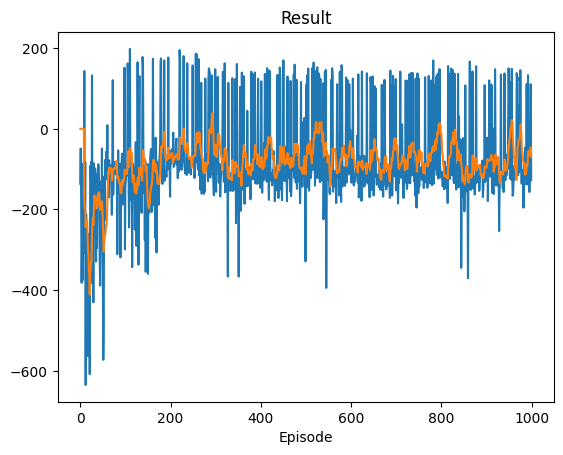

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
rewards, returns = trainIters(actor, critic, episode_rewards, 1000)

## Saving simultations results in gif

In [ ]:
import imageio

def saveanimation(frames,address="./lra2c.gif"):
    imageio.mimwrite(address, frames)

In [ ]:
env1 = gym.make("Lon")

## Testing the Agent

In [ ]:
rewards = []
frames = []

for i in range(5):
    done = False
    t_rewards = 0
    state = env1.reset()

    step = 0

    while not done:
        # frames.append(env1.render())
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)

        action = dist.sample()
        obs, reward, done, info = env1.step(action.cpu().numpy())
        # done = term or trunc
        step += 1
        # if step > 1000:
        #   done = True

        t_rewards += reward
        if done:
            break
        else:
            state = obs

    rewards.append(t_rewards)
    print(f"Episode {i}: Reward {t_rewards}")

# saveanimation(frames)
env1.close()

Episode 0: Reward 109.68124249423906
Episode 1: Reward 138.37451479029974
Episode 2: Reward 125.61348408725132
Episode 3: Reward 106.8672107380387
Episode 4: Reward -120.10121344174814


In [ ]:
torch.save(actor.state_dict(), "lra2ca_final.pt")
torch.save(critic.state_dict(), "lra2cc_final.pt")


In [ ]:
sum(rewards)/5

72.08704773361613

In [ ]:
rewards

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[109.68124249423906,
 138.37451479029974,
 125.61348408725132,
 106.8672107380387,
 -120.10121344174814]

In [ ]:
episodes = [1,2,3,4,5]
steps = []

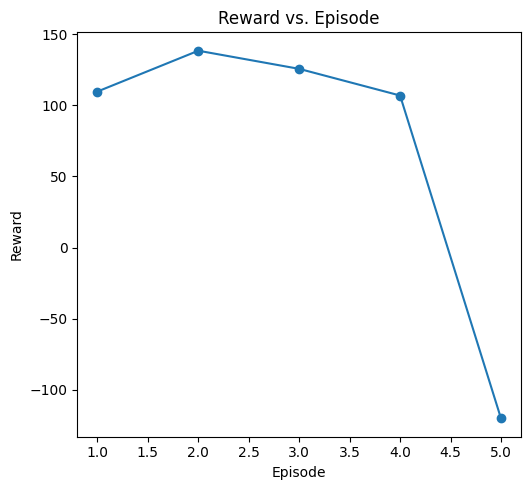

In [ ]:
# Plotting rewards vs. episode
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(episodes, rewards, marker='o')
plt.title('Reward vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()